In [1]:
%load_ext watermark
%watermark -a "Teresiah Kahura" -d -t -v -p numpy,pandas,matplotlib -g

Teresiah Kahura 2020-08-08 14:02:51 

CPython 3.7.3
IPython 7.16.1

numpy 1.18.5
pandas 0.24.2
matplotlib 3.0.3
Git hash: 26f5332e6506f83cc12a9d8f7aadc88994e7ef23


In [2]:
from __future__ import print_function
%matplotlib inline

import datetime

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

In [3]:
path = '/Users/teresiahkahura/Desktop/ds/SB-Capstone2/data/processed/reviews2.pkl'
df = pd.read_pickle(path)

assert df.shape == (3268, 2)


In [4]:
df.head()

,text,label
0,Fascinating view into the past: This book is f...,1
1,A very amusing look at the past: I was hoping ...,1
2,Didn't like...: I didn't like this version of ...,0
3,"Two Divas,that should shut up!: Here are two s...",0
4,Movie Version is Much better!: The movie versi...,0


# Preprocessing

In [5]:
x = df["text"]
y = df["label"].values

In [6]:
tokenizer = Tokenizer(lower=True, filters='\d*!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split = ' ')
tokenizer.fit_on_texts(x)

In [7]:
def get_sequence_of_tokens(corpus):
    
    
    total_words = len(tokenizer.word_index) + 1
    
     
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        input_sequences.append(token_list)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(x)

In [8]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,))
   
    predictors = input_sequences[:,:-1]
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(inp_sequences)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=0.30, random_state=42)

# Setting up RNN

In [10]:
def build_model():
  opt = Adam(lr=0.01)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(total_words, 128))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model

rnn_model = build_model()

In [11]:
!rm -r /tmp/logs/

In [12]:
logdir = os.path.join("/tmp/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='/tmp/sentiment_analysis_rnn.hdf5', 
                                                  verbose = 1, 
                                                  save_best_only= True)

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_rnn = rnn_model.fit(x_train, y_train, epochs = 10, validation_split=0.1, 
                              callbacks = [tb_callback, checkpoint])

Epoch 1/10
 1/65 [..............................] - ETA: 0s - loss: 0.6777 - accuracy: 0.6250WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
65/65 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.5019
Epoch 00001: val_loss improved from inf to 0.72197, saving model to /tmp/sentiment_analysis_rnn.hdf5
65/65 [==============================] - 9s 142ms/step - loss: 0.8403 - accuracy: 0.5019 - val_loss: 0.7220 - val_accuracy: 0.4585
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.8062 - accuracy: 0.5185
Epoch 00002: val_loss improved from 0.72197 to 0.70052, saving model to /tmp/sentiment_analysis_rnn.hdf5
65/65 [==============================] - 9s 132ms/step - loss: 0.8062 - accu

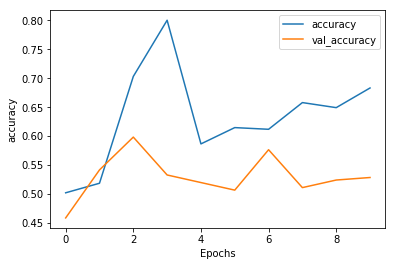

In [14]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+ metric])
  plt.show()

plot_graphs(history_rnn, 'accuracy')

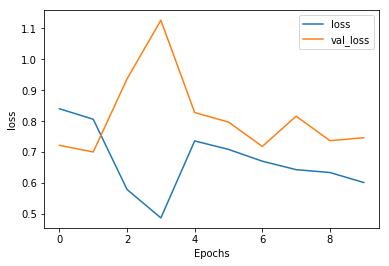

In [15]:
plot_graphs(history_rnn, 'loss')

In [16]:
results = rnn_model.evaluate(x_test, y_test)
print(results)

31/31 [==============================] - 1s 24ms/step - loss: 0.7586 - accuracy: 0.5698
[0.7586163878440857, 0.5698267221450806]
